In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_BN(conv_num=1):
    init_channel = 128
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel/(2**int((i+1)/4))), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(BatchNormalization())
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 128)        512       
_________________________________________________________________
activation (Activation)      (None, 16000, 128)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2048000)           0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 2048000)           8192000   
_________________________________________________________________
dense (Dense)                (None, 16)                32768016  
Total params: 40,961,296
Trainable params: 36,865,040
Non-trainable pa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 128)         0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_44 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 128)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7658 - acc: 0.4550
Epoch 00001: val_loss improved from inf to 1.47387, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_BN_6_conv_checkpoint/001-1.4739.hdf5
36805/36805 [==============================] - 188s 5ms/sample - loss: 1.7658 - acc: 0.4550 - val_loss: 1.4739 - val_acc: 0.5539
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0918 - acc: 0.6686
Epoch 00002: val_loss improved from 1.47387 to 1.00929, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_BN_6_conv_checkpoint/002-1.0093.hdf5
36805/36805 [==============================] - 184s 5ms/sample - loss: 1.0918 - acc: 0.6686 - val_loss: 1.0093 - val_acc: 0.6956
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9041 - acc: 0.7330
Epoch 00003: val_loss improved from 1.00929 to 0.83211, saving 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1444 - acc: 0.9625
Epoch 00025: val_loss did not improve from 0.51580
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.1445 - acc: 0.9625 - val_loss: 0.5301 - val_acc: 0.8553
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1361 - acc: 0.9654
Epoch 00026: val_loss improved from 0.51580 to 0.49584, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_BN_6_conv_checkpoint/026-0.4958.hdf5
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.1361 - acc: 0.9654 - val_loss: 0.4958 - val_acc: 0.8668
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1169 - acc: 0.9718
Epoch 00027: val_loss did not improve from 0.49584
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.1169 - acc: 0.9718 - val_loss: 0.5337 - val_acc: 0.8602
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1157 -

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0336 - acc: 0.9943
Epoch 00054: val_loss did not improve from 0.49326
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.0336 - acc: 0.9943 - val_loss: 0.5710 - val_acc: 0.8710
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0307 - acc: 0.9949
Epoch 00055: val_loss did not improve from 0.49326
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.0310 - acc: 0.9948 - val_loss: 0.5689 - val_acc: 0.8684
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0527 - acc: 0.9874
Epoch 00056: val_loss did not improve from 0.49326
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.0527 - acc: 0.9874 - val_loss: 0.6151 - val_acc: 0.8607
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0308 - acc: 0.9946
Epoch 00057: val_loss did not improve from 0.49326
36805/36805 [========

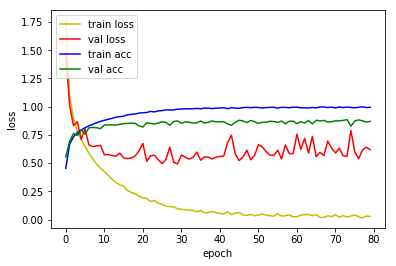

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.5478 - acc: 0.8474
Loss: 0.5478097885816144 Accuracy: 0.847352

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9388 - acc: 0.4016
Epoch 00001: val_loss improved from inf to 1.56341, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_BN_7_conv_checkpoint/001-1.5634.hdf5
36805/36805 [==============================] - 191s 5ms/sample - loss: 1.9388 - acc: 0.4016 - val_loss: 1.5634 - val_acc: 0.5003
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1778 - acc: 0.6426
Epoch 00002: val_loss improved from 1.56341 to 0.97998, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_BN_7_conv_checkpoint/002-0.9800.hdf5
36805/36805 [==============================] - 185s 5ms/sample - loss: 1.1777 - acc: 0.6426 - val_loss: 0.9800 - val_acc: 0.7051
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1270 - acc: 0.9650
Epoch 00025: val_loss did not improve from 0.29861
36805/36805 [==============================] - 185s 5ms/sample - loss: 0.1270 - acc: 0.9650 - val_loss: 0.3207 - val_acc: 0.9210
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1090 - acc: 0.9717
Epoch 00026: val_loss improved from 0.29861 to 0.28922, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_BN_7_conv_checkpoint/026-0.2892.hdf5
36805/36805 [==============================] - 185s 5ms/sample - loss: 0.1091 - acc: 0.9717 - val_loss: 0.2892 - val_acc: 0.9206
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1044 - acc: 0.9730
Epoch 00027: val_loss did not improve from 0.28922
36805/36805 [==============================] - 185s 5ms/sample - loss: 0.1045 - acc: 0.9729 - val_loss: 0.3183 - val_acc: 0.9129
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0369 - acc: 0.9916
Epoch 00054: val_loss did not improve from 0.28505
36805/36805 [==============================] - 185s 5ms/sample - loss: 0.0370 - acc: 0.9916 - val_loss: 0.3394 - val_acc: 0.9159
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0310 - acc: 0.9936
Epoch 00055: val_loss did not improve from 0.28505
36805/36805 [==============================] - 185s 5ms/sample - loss: 0.0310 - acc: 0.9936 - val_loss: 0.3114 - val_acc: 0.9257
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0210 - acc: 0.9971
Epoch 00056: val_loss did not improve from 0.28505
36805/36805 [==============================] - 185s 5ms/sample - loss: 0.0211 - acc: 0.9970 - val_loss: 0.4546 - val_acc: 0.8970
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0430 - acc: 0.9890
Epoch 00057: val_loss did not improve from 0.28505
36805/36805 [========

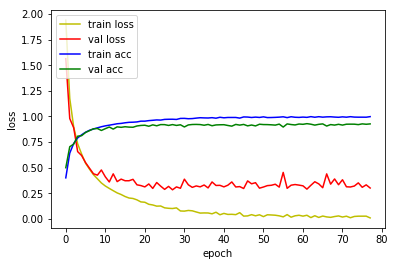

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.3399 - acc: 0.9043
Loss: 0.3399248241511708 Accuracy: 0.90425754

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9011 - acc: 0.4158
Epoch 00001: val_loss improved from inf to 1.59456, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_BN_8_conv_checkpoint/001-1.5946.hdf5
36805/36805 [==============================] - 196s 5ms/sample - loss: 1.9009 - acc: 0.4159 - val_loss: 1.5946 - val_acc: 0.5155
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9961 - acc: 0.7122
Epoch 00002: val_loss improved from 1.59456 to 0.83291, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_BN_8_conv_checkpoint/002-0.8329.hdf5
36805/36805 [==============================] - 186s 5ms/sample - loss: 0.9960 - acc: 0.7122 - val_loss: 0.8329 - val_acc: 0.7554
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0689 - acc: 0.9820
Epoch 00025: val_loss did not improve from 0.17735
36805/36805 [==============================] - 186s 5ms/sample - loss: 0.0689 - acc: 0.9820 - val_loss: 0.2007 - val_acc: 0.9392
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0600 - acc: 0.9854
Epoch 00026: val_loss did not improve from 0.17735
36805/36805 [==============================] - 186s 5ms/sample - loss: 0.0602 - acc: 0.9853 - val_loss: 0.2570 - val_acc: 0.9278
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0747 - acc: 0.9803
Epoch 00027: val_loss did not improve from 0.17735
36805/36805 [==============================] - 186s 5ms/sample - loss: 0.0747 - acc: 0.9803 - val_loss: 0.1953 - val_acc: 0.9448
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0512 - acc: 0.9878
Epoch 00028: val_loss did not improve from 0.17735
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0222 - acc: 0.9947
Epoch 00054: val_loss did not improve from 0.17530
36805/36805 [==============================] - 186s 5ms/sample - loss: 0.0223 - acc: 0.9946 - val_loss: 0.1828 - val_acc: 0.9529
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0163 - acc: 0.9970
Epoch 00055: val_loss did not improve from 0.17530
36805/36805 [==============================] - 186s 5ms/sample - loss: 0.0163 - acc: 0.9970 - val_loss: 0.1904 - val_acc: 0.9515
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0087 - acc: 0.9989
Epoch 00056: val_loss did not improve from 0.17530
36805/36805 [==============================] - 186s 5ms/sample - loss: 0.0087 - acc: 0.9989 - val_loss: 0.1956 - val_acc: 0.9506
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0098 - acc: 0.9987
Epoch 00057: val_loss did not improve from 0.17530
36805/36805 [=====================

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.9984
Epoch 00084: val_loss did not improve from 0.17530
36805/36805 [==============================] - 186s 5ms/sample - loss: 0.0084 - acc: 0.9984 - val_loss: 0.1850 - val_acc: 0.9555
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0053 - acc: 0.9992
Epoch 00085: val_loss did not improve from 0.17530
36805/36805 [==============================] - 186s 5ms/sample - loss: 0.0054 - acc: 0.9992 - val_loss: 0.1992 - val_acc: 0.9532
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9966
Epoch 00086: val_loss did not improve from 0.17530
36805/36805 [==============================] - 186s 5ms/sample - loss: 0.0133 - acc: 0.9966 - val_loss: 0.2151 - val_acc: 0.9509
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0117 - acc: 0.9971
Epoch 00087: val_loss did not improve from 0.17530
36805/36805 [========

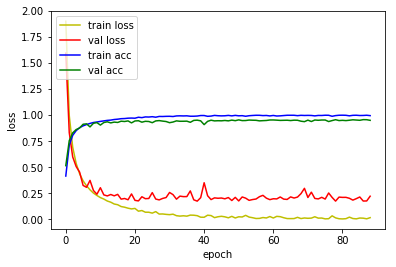

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.2236 - acc: 0.9360
Loss: 0.22356352788760778 Accuracy: 0.93603325

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7370 - acc: 0.4733
Epoch 00001: val_loss improved from inf to 1.46946, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_BN_9_conv_checkpoint/001-1.4695.hdf5
36805/36805 [==============================] - 201s 5ms/sample - loss: 1.7369 - acc: 0.4733 - val_loss: 1.4695 - val_acc: 0.5833
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9273 - acc: 0.7398
Epoch 00002: val_loss improved from 1.46946 to 0.73683, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_BN_9_conv_checkpoint/002-0.7368.hdf5
36805/36805 [==============================] - 187s 5ms/sample - loss: 0.9273 - acc: 0.7398 - val_loss: 0.7368 - val_acc: 0.8067
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0605 - acc: 0.9844
Epoch 00025: val_loss did not improve from 0.17912
36805/36805 [==============================] - 187s 5ms/sample - loss: 0.0605 - acc: 0.9844 - val_loss: 0.1894 - val_acc: 0.9455
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0517 - acc: 0.9877
Epoch 00026: val_loss did not improve from 0.17912
36805/36805 [==============================] - 187s 5ms/sample - loss: 0.0517 - acc: 0.9877 - val_loss: 0.1944 - val_acc: 0.9394
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0489 - acc: 0.9883
Epoch 00027: val_loss did not improve from 0.17912
36805/36805 [==============================] - 187s 5ms/sample - loss: 0.0489 - acc: 0.9883 - val_loss: 0.1930 - val_acc: 0.9460
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0435 - acc: 0.9901
Epoch 00028: val_loss did not improve from 0.17912
36805/36805 [========

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0284 - acc: 0.9920
Epoch 00054: val_loss did not improve from 0.16979
36805/36805 [==============================] - 187s 5ms/sample - loss: 0.0284 - acc: 0.9920 - val_loss: 0.2092 - val_acc: 0.9481
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.9987
Epoch 00055: val_loss did not improve from 0.16979
36805/36805 [==============================] - 187s 5ms/sample - loss: 0.0085 - acc: 0.9987 - val_loss: 0.2029 - val_acc: 0.9476
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0176 - acc: 0.9959
Epoch 00056: val_loss did not improve from 0.16979
36805/36805 [==============================] - 187s 5ms/sample - loss: 0.0176 - acc: 0.9959 - val_loss: 0.1904 - val_acc: 0.9518
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9989
Epoch 00057: val_loss did not improve from 0.16979
36805/36805 [========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0198 - acc: 0.9940
Epoch 00084: val_loss did not improve from 0.16979
36805/36805 [==============================] - 187s 5ms/sample - loss: 0.0198 - acc: 0.9940 - val_loss: 0.1868 - val_acc: 0.9532
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0047 - acc: 0.9993
Epoch 00085: val_loss did not improve from 0.16979
36805/36805 [==============================] - 187s 5ms/sample - loss: 0.0047 - acc: 0.9993 - val_loss: 0.1832 - val_acc: 0.9569
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9964
Epoch 00086: val_loss did not improve from 0.16979
36805/36805 [==============================] - 187s 5ms/sample - loss: 0.0134 - acc: 0.9964 - val_loss: 0.1996 - val_acc: 0.9534

1D_CNN_custom_2_ch_128_BN_9_conv Model


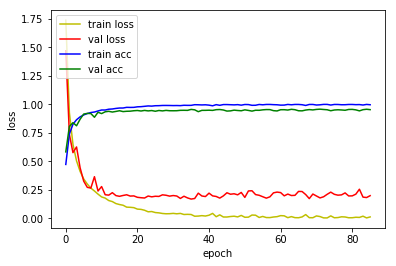

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2347 - acc: 0.9379
Loss: 0.23471872432395305 Accuracy: 0.9379024



In [10]:
for i in range(6, 10):
    base = '1D_CNN_custom_2_ch_128_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_2_ch_128_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(6, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_2_ch_128_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.3399 - acc: 0.9043
Loss: 0.3399248241511708 Accuracy: 0.90425754

1D_CNN_custom_2_ch_128_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_69 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_58 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_70 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_59 (Activation)   (None

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2347 - acc: 0.9379
Loss: 0.23471872432395305 Accuracy: 0.9379024


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(6, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_2_ch_128_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.3664 - acc: 0.9105
Loss: 0.36638891243860355 Accuracy: 0.91048807

1D_CNN_custom_2_ch_128_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_69 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_58 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_70 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_59 (Activation)   (Non

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2877 - acc: 0.9340
Loss: 0.28767999671863803 Accuracy: 0.9339564
